In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate

import scipy.ndimage

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 22})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')


In [2]:
# file = rf"H:\phd stuff\tidy3d\output\LSU Data\transmission_10.89.h5"
# file_host = rf"H:\phd stuff\tidy3d\output\LSU Data\transmission_10.89_host.h5"
# file = rf"H:\phd stuff\tidy3d\output\LSU Data\transmission_10.89_gaussian_source_host_air.h5"
# file_host = rf"H:\phd stuff\tidy3d\output\LSU Data\transmission_10.89_gaussian_source_host_decaline.h5"
file = rf"H:\phd stuff\tidy3d\output\LSU Data\transmission_gaussian.h5"
file_host = rf"H:\phd stuff\tidy3d\output\LSU Data\transmission_gaussian_host.h5"
with h5py.File(file, 'r') as h5f:
    data_air = {
            'transmission_right':h5f["transmission_right"][:],#shape (n_index, sizes, freqs)
            'transmission_left':h5f["transmission_left"][:],
            'power_far_field':h5f["power_far_field"][:],#shape (n_index, sizes, theta,phi,freqs)
            'power_far_field_ref':h5f["power_far_field_ref"][:],
            'nu(a/lambda)':h5f["nu(a/lambda)"][:],
            "raw_freqs(Hz)":h5f["raw_freqs(Hz)"][:],
            "sizes":h5f["sizes"][:],
            "cell_size":h5f["cell_size"],
            "a":h5f["a"],
            "eps":h5f["eps"][:]
                        
            }
    
with h5py.File(file_host, 'r') as h5f:
    data_host = {
            'transmission_right':h5f["transmission_right"][:],
            'transmission_left':h5f["transmission_left"][:],
            'power_far_field':h5f["power_far_field"][:],
            'power_far_field_ref':h5f["power_far_field_ref"][:],
            'nu(a/lambda)':h5f["nu(a/lambda)"][:],
            "raw_freqs(Hz)":h5f["raw_freqs(Hz)"][:],
            "sizes":h5f["sizes"][:],
            "cell_size":h5f["cell_size"],
            "a":h5f["a"],
            "eps":h5f["eps"][:],
            "eps_host":np.array([2.030625])
                        
            }

In [3]:
folder_experimental = rf"H:\phd stuff\tidy3d\output\Experimental Data\data_lsu_air_decaline"
transmission_experimental_air = []
transmission_experimental_decaline = []

for filename in os.listdir(folder_experimental):
    if Path(filename).suffix == ".txt":
        continue

    with open(os.path.join(folder_experimental,filename), 'rb') as file:
        content = file.read()
        
    # Decode the binary content to a string
    decoded_content = content.decode('utf-8')

    # Split the content into lines
    lines = decoded_content.split('\r\n')

    # Initialize an empty list to store the parsed values
    data = []

    # Loop through each line and split by the comma
    for line in lines:
        if line:  # Skip any empty lines
            value1, value2 = line.split(',')
            data.append([float(value1), float(value2)])  # Convert values to float

    if "decaline" in filename:
        transmission_experimental_decaline.append((data))
    else: 
        transmission_experimental_air.append(data)


transmission_experimental_air = np.array(transmission_experimental_air)
transmission_experimental_decaline = np.array(transmission_experimental_decaline)

    

In [4]:
sizes_exp = [5.4,8.4,9.4,10.4,11.4,12.4,14.5,20.5]


In [5]:
r_proj =  1e6
theta_proj = np.linspace(0, np.pi/2, 280)
phi_proj = np.linspace(0,2*np.pi, 280)
indices_0_30 = np.where(np.bool_(theta_proj*180/np.pi >=0) & np.bool_(theta_proj*180/np.pi <=15))[0]
r,theta,phi = r_proj,theta_proj[indices_0_30],phi_proj
# Calculate the differential surface area element in spherical coordinates
dA_1= (r ** 2) * np.sin(theta_proj) * np.diff(theta_proj)[0] * np.diff(phi)[0]
dA_2= (r ** 2) * np.sin(theta) * np.diff(theta)[0] * np.diff(phi)[0]

#References 
transmission_0_n_h_1 = ((data_air["power_far_field_ref"][indices_0_30,:,:])* dA_2[:,np.newaxis,np.newaxis]).sum(axis=(0,1))
transmission_0_n_h_1_425 = ((data_host["power_far_field_ref"][indices_0_30,:,:])* dA_2[:,np.newaxis,np.newaxis]).sum(axis=(0,1))

#Convulution 
transmissionValues_air = np.zeros(shape=(2, 11, 450))
transmissionValues_Decaline = np.zeros(shape=(2, 11, 450))
transmissionValues_air_gaussian = np.zeros(shape=(2, 11, 450))
transmissionValues_decaline_gaussian = np.zeros(shape=(2, 11, 450))

for n,item in enumerate(data_air["eps"]):
 for i,item in enumerate(data_air["sizes"]):
    
    #Decaline
    power_data = data_host["power_far_field"][n,i]
    transmission_normalized_decaline =  ((power_data[indices_0_30,:,:])* dA_2[:,np.newaxis,np.newaxis]).sum(axis=(0,1))/transmission_0_n_h_1_425
    transmissionValues_Decaline[n,i] =transmission_normalized_decaline
    #Air
    # low_nu_indices = np.where(data_air["nu(a/lambda)"]<=0.53)[0]
    # large_nu_indices = np.where(data_air["nu(a/lambda)"]>0.53)[0]
    power_data = data_air["power_far_field"][n,i]
    transmission_normalized = ((power_data[indices_0_30,:,:])* dA_2[:,np.newaxis,np.newaxis]).sum(axis=(0,1))/transmission_0_n_h_1 
    transmissionValues_air[n,i] = transmission_normalized
    # transmission_high_nu = (power_data[np.ix_(indices_0_30,np.arange(power_data.shape[1]),large_nu_indices)]* dA_2[:,np.newaxis,np.newaxis]).sum(axis=(0,1))
    # transmission_low_nu = (power_data[:,:,low_nu_indices]* dA_1[:,np.newaxis,np.newaxis]).sum(axis=(0,1))
    # transmission_normalized = np.concatenate((transmission_low_nu,transmission_high_nu),axis=0)/transmission_0_n_h_1
    # transmissionValues_air.append(transmission_normalized)

    # Apply Gaussian smoothing
    sigma = 32  # Adjust for more/less smoothing
    smoothed_transmission = scipy.ndimage.gaussian_filter1d(transmission_normalized, sigma)
    transmissionValues_air_gaussian[n,i]=smoothed_transmission
    
    smoothed_transmission_host = scipy.ndimage.gaussian_filter1d(transmission_normalized_decaline, 5)
    transmissionValues_decaline_gaussian[n,i]=smoothed_transmission_host

    








In [6]:
sigma_physical = np.diff(data_air["nu(a/lambda)"])[0] * sigma

sigma_physical # in units of a/\lambda 

0.031154947502386676

In [7]:
np.shape(transmissionValues_air)

(2, 11, 450)

In [8]:
# indices_experimental = [0,3,4]
# indices_simulations = [5,9,10]
indices_experimental = [4]
indices_simulations = [10]

In [ ]:
# structure_1 = AM.loadFromFile(key = tidy3dAPI, file_path=rf"H:\phd stuff\tidy3d\data\20250327 Far Field Transmission LSU Angled Test 1803_ff_double_size_perm_9.0\z_incidence\ak4_1000_eps_9p0_phih5_0p1895_phiL_0p1803_size_1.txt",get_ref=True) # I like this one
# structure_1 = AM.loadFromFile(key = tidy3dAPI, file_path=rf"H:\phd stuff\tidy3d\data\20250327 Far Field Transmission LSU Angled Test 2073_ff_double_size_periodic_perm_9.0\z_incidence\ak4_1000_eps_9p0_phih5_0p2177_phiL_0p2073_size_1.txt",get_ref=True)
# structure_1 = AM.loadFromFile(key = tidy3dAPI, file_path=rf"H:\phd stuff\tidy3d\data\20250327 Far Field Transmission LSU Angle Test 1895_ff_double_size_periodic_3_perm_9.0\z_incidence\ak4_1000_eps_9p0_phih5_0p1895_phiL_0p1803_size_1.txt",get_ref=True) #4x size ff 1895
structure_1 = AM.loadFromFile(key = tidy3dAPI, file_path=rf"H:\phd stuff\tidy3d\data\20250328 Far Field Transmission LSU Angle Test 2073_ff_4x_size_perm_9.0\z_incidence\ak4_1000_eps_9p0_phih5_0p2177_phiL_0p2073_size_1.txt",get_ref=True)





Configured successfully.


Output()

14:00:15 W. Europe Standard Time loading simulation from H:\phd                 
                                 stuff\tidy3d/output/data\20250327 Far Field    
                                 Transmission LSU Angle Test                    
                                 1895_ff_double_size_periodic_3_perm_9.0\z_incid
                                 ence\ak4_1000_eps_9p0_phih5_0p1895_phiL_0p1803_
                                 size_1.txt/Data_0.hdf5

14:00:16 W. Europe Standard Time WARNING: Simulation final field decay value of 
                                 1.15e-11 is greater than the simulation shutoff
                                 threshold of 1e-20. Consider running the       
                                 simulation again with a larger 'run_time'      
                                 duration for more accurate results.            

Output()

14:03:28 W. Europe Standard Time loading simulation from H:\phd                 
                                 stuff\tidy3d/output/data\20250327 Far Field    
                                 Transmission LSU Angle Test                    
                                 1895_ff_double_size_periodic_3_perm_9.0\z_incid
                                 ence\ak4_1000_eps_9p0_phih5_0p1895_phiL_0p1803_
                                 size_1.txt/Data.hdf5

14:03:39 W. Europe Standard Time WARNING: Structure at 'structures[0]' has      
                                 bounds that extend exactly to simulation edges.
                                 This can cause unexpected behavior. If         
                                 intending to extend the structure to infinity  
                                 along one dimension, use td.inf as a size      
                                 variable instead to make this explicit.        

                                 WARNING: Suppressed 15 WARNING messages.       

14:06:31 W. Europe Standard Time WARNING: Simulation final field decay value of 
                                 1.28e-11 is greater than the simulation shutoff
                                 threshold of 1e-20. Consider running the       
                                 simulation again with a larger 'run_time'      
                                 duration for more accurate results.            

                                 WARNING: Warning messages were found in the    
                                 solver log. For more information, check        
                                 'SimulationData.log' or use                    
                                 'web.download_log(task_id)'.                   

14:06:32 W. Europe Standard Time Billed flex credit cost: 22.626.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

In [17]:
sim_data, sim_data0 = structure_1.sim_data, structure_1.sim_data0
projected_field_data_0 = sim_data0["far_field"].power.squeeze().values
projected_field_data = sim_data["far_field"].power.squeeze().values

indices_degrees = np.where(np.bool_(theta_proj*180/np.pi >=15) & np.bool_(theta_proj*180/np.pi <=30))[0]
dA= (r ** 2) * np.sin(theta_proj[indices_degrees]) * np.diff(theta_proj[indices_degrees])[0] * np.diff(phi)[0]


transmission_0_15_degrees = ((projected_field_data_0[indices_degrees,:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1))
transmission_normalized_15_degrees = ((projected_field_data[indices_degrees,:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1))/transmission_0_15_degrees 
sigma_tilted = 36
smoothed_transmission_15_degrees = scipy.ndimage.gaussian_filter1d(transmission_normalized_15_degrees, sigma_tilted)


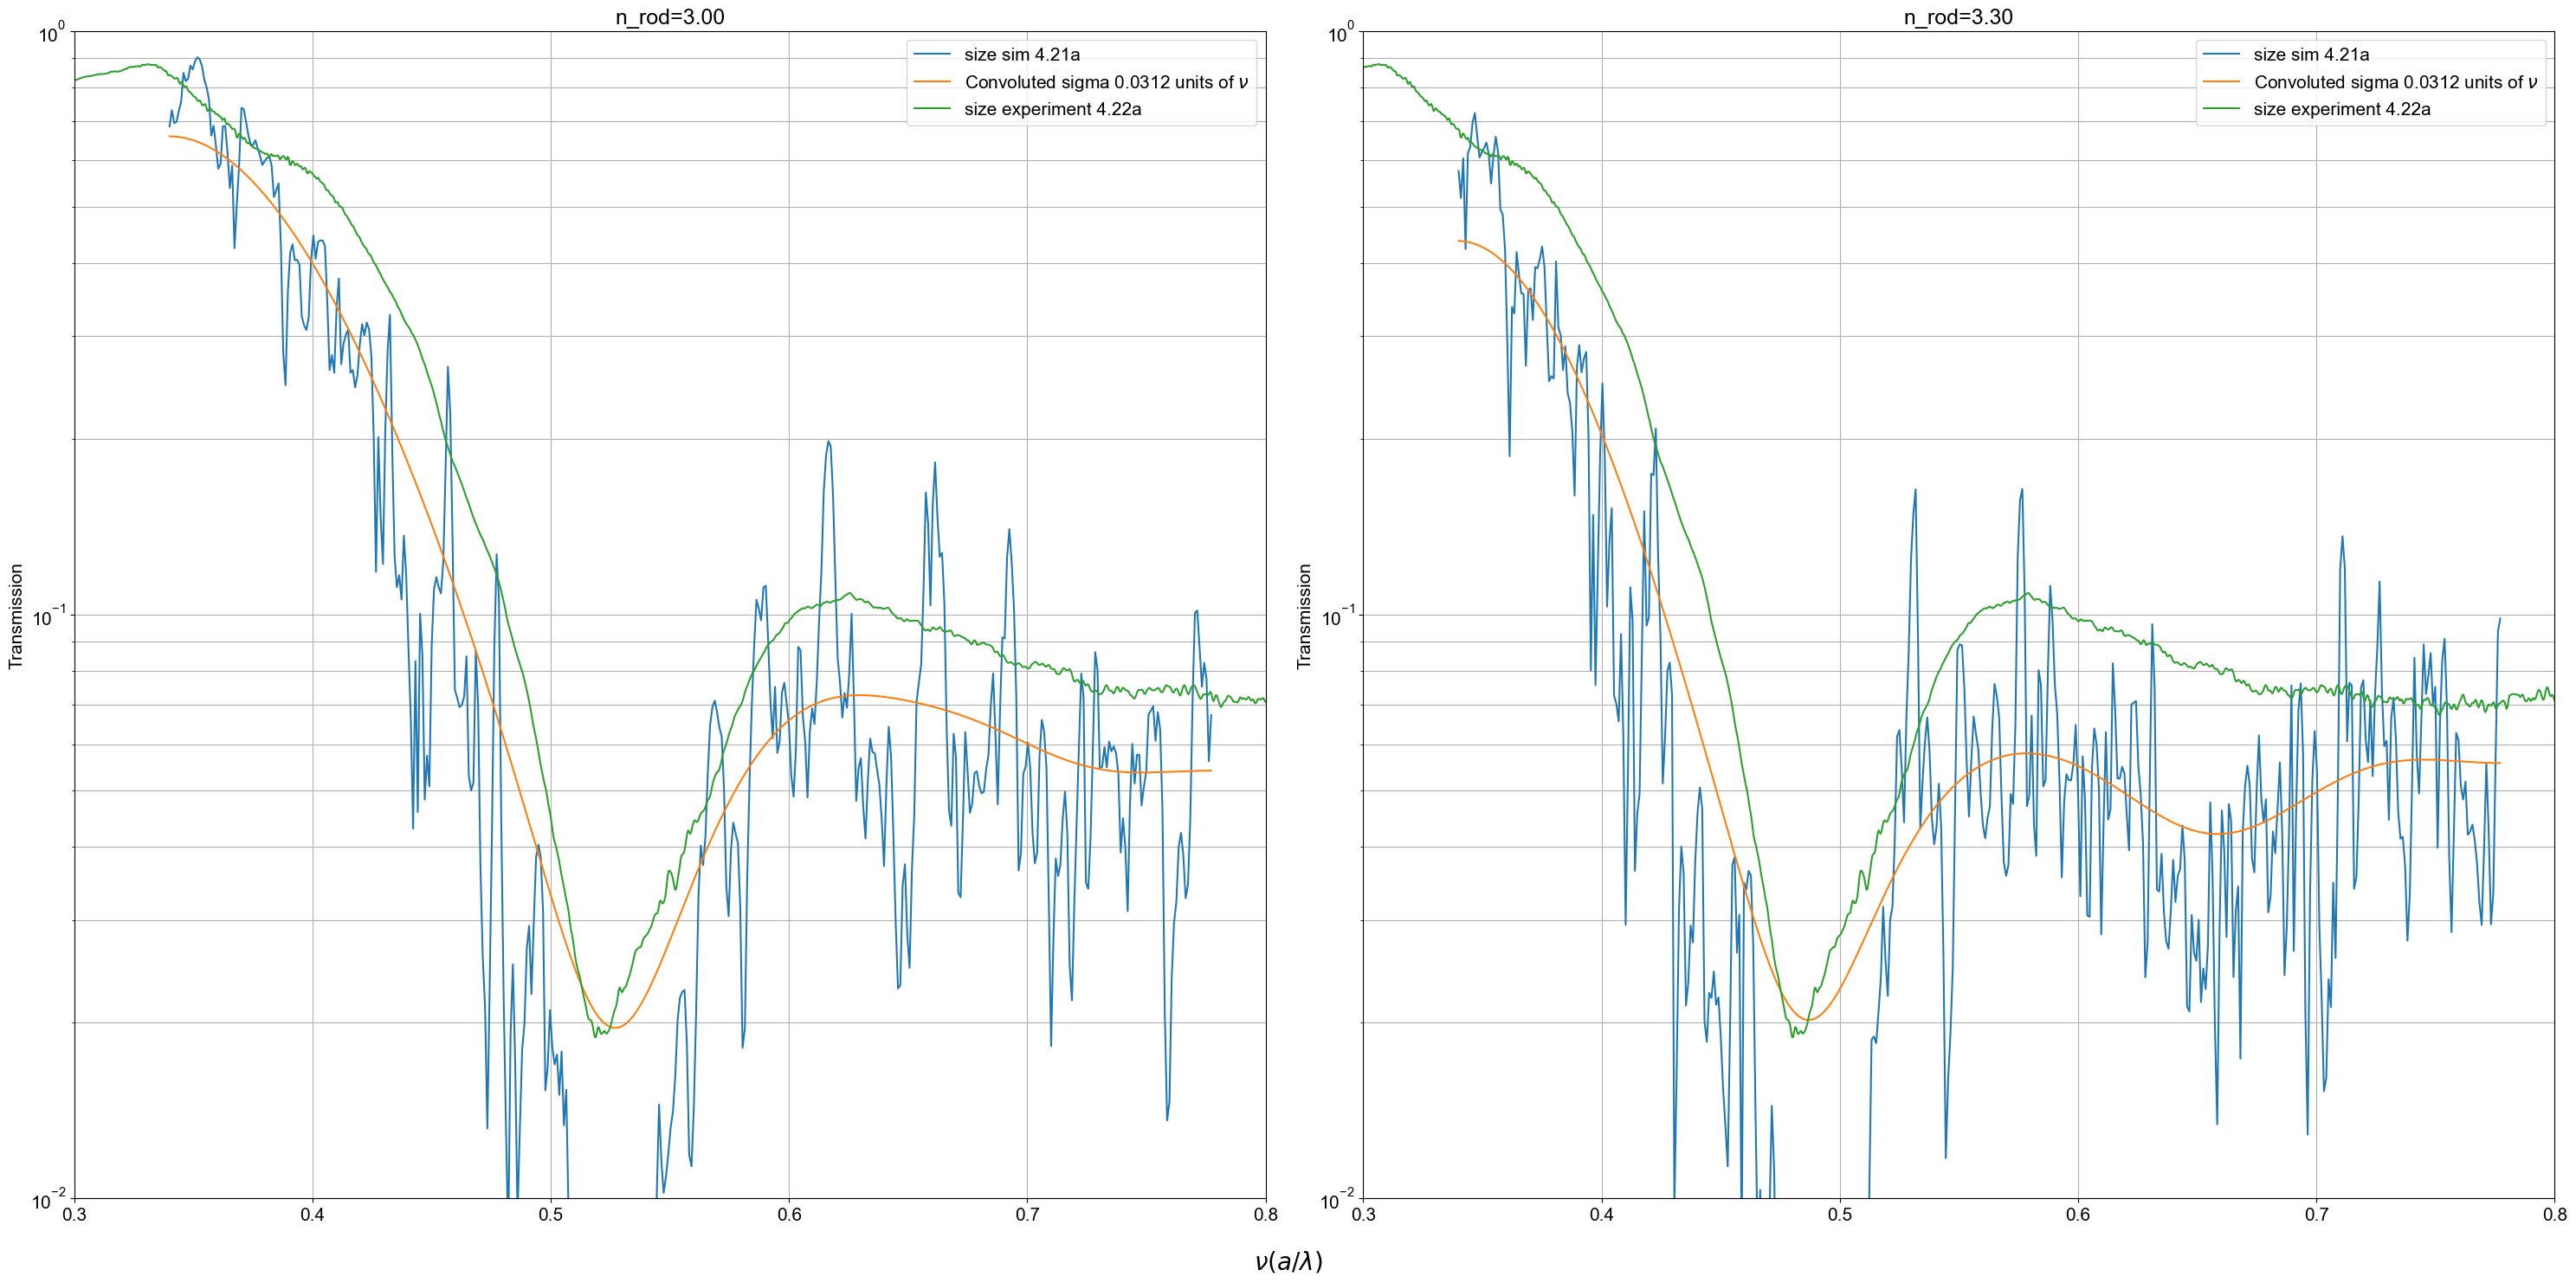

In [18]:
plt.rcParams.update({'font.size': 15})  
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))
k,l=0,0

for n,item in enumerate(data_air["eps"]):
 for i, index in enumerate(indices_experimental):
    ax[l].plot(data_air["nu(a/lambda)"],transmissionValues_air[n,indices_simulations[i]],label=rf"size sim {data_air["sizes"][indices_simulations[i]]*14.3/(3.4) :.2f}a")
    ax[l].plot(data_air["nu(a/lambda)"],transmissionValues_air_gaussian[n,indices_simulations[i]],label=rf"Convoluted sigma {sigma_physical:.4f} units of $\nu$")
    if n == 0:
      adjust = 0.875
    else:
      adjust = 0.81
    ax[l].plot(2.7*adjust/(1e4/transmission_experimental_air[4,:,0]),transmission_experimental_air[4,:,1],label=rf"size experiment {sizes_exp[indices_experimental[i]]/(2.7) :.2f}a")
    ax[l].legend(loc=1)
    ax[l].grid(True, which="both")
    ax[l].set_yscale("log")
    ax[l].set_xlim(0.3,0.8)
    ax[l].set_ylim(1e-2,1)
    ax[l].set_ylabel("Transmission")
    ax[l].set_title(rf"n_rod={np.sqrt(item):.2f}")

 l+=1

fig.supxlabel(rf'$\nu (a/\lambda)$', fontsize=20)
plt.tight_layout()
plt.show()


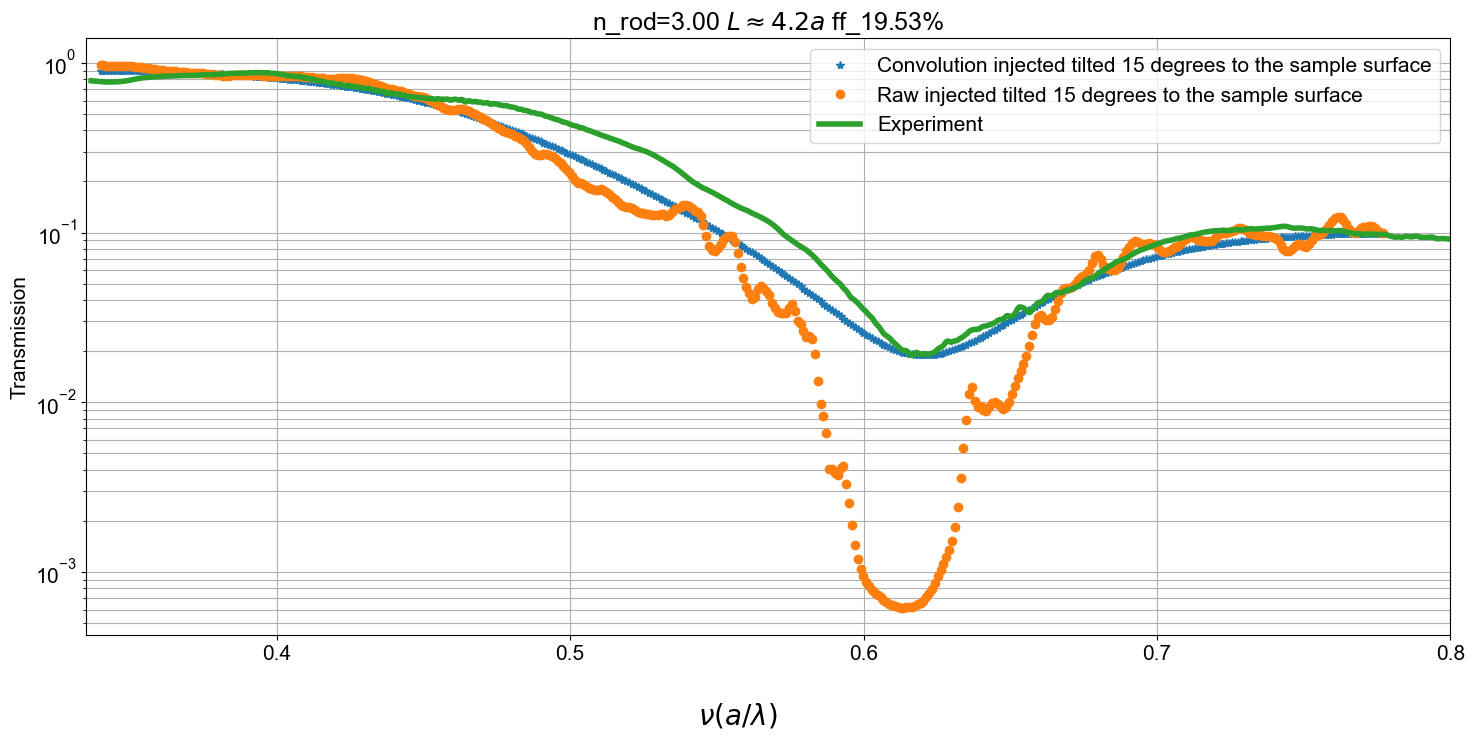

In [33]:
plt.rcParams.update({'font.size': 15})  
fig, ax = plt.subplots(figsize=(15, 7.5))

# ax.plot(data_air["nu(a/lambda)"],transmissionValues_air_gaussian[0,indices_simulations[-1]],"--",label=rf"Source injected normal to the sample surface")
ax.plot(data_air["nu(a/lambda)"],smoothed_transmission_15_degrees,"*",label=rf"Convolution injected tilted 15 degrees to the sample surface")
ax.plot(data_air["nu(a/lambda)"],transmission_normalized_15_degrees,"o",label=rf"Raw injected tilted 15 degrees to the sample surface")

adjust = 1.04
ax.plot(2.7*adjust/(1e4/transmission_experimental_air[4,:,0]),transmission_experimental_air[4,:,1],linewidth=4,label=rf"Experiment")
ax.legend(loc=1)
ax.grid(True, which="both")
ax.set_yscale("log")
ax.set_xlim(0.335,0.8)
ax.set_ylabel("Transmission")
ax.set_title(rf"n_rod={3:.2f} $L\approx 4.2a$ ff_19.53%")


fig.supxlabel(rf'$\nu (a/\lambda)$', fontsize=20)
plt.tight_layout()
plt.show()
